In [1]:
%load_ext rpy2.ipython
%R library(dplyr); library(ggplot2); library(gridExtra); library(vegan)

//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: permute

  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: lattice

  res = super(Function, self).__call__(*new_args, **n

array(['vegan', 'lattice', 'permute', 'gridExtra', 'ggplot2', 'dplyr',
       'tools', 'stats', 'graphics', 'grDevices', 'utils', 'datasets',
       'methods', 'base'], 
      dtype='|S9')

Playing with Eric's OV-2 metagenomes recruited to SPAM SAGs

In [13]:
%%R
df <- read.table("../data/summary_tbls/160721_summary_table_pctid95_minlen150_overlap95.txt", sep="\t", header=TRUE)
head(df)

         sag         metagenome Percent_scaffolds_with_any_coverage
1 AD-967-E21 OV-2_P2_metagenome                                 100
2 AD-967-E21 OV-2_P3_metagenome                                 100
3 AG-128-L10 OV-2_P2_metagenome                                 100
4 AG-128-L10 OV-2_P3_metagenome                                 100
5 AG-138-D06 OV-2_P2_metagenome                                 100
6 AG-138-D06 OV-2_P3_metagenome                                 100
  Percent_of_reference_bases_covered Average_coverage total_reads_recruited
1                           2.511505       0.17451201                  1558
2                           3.604227       0.17334084                  1827
3                          14.523965       0.25060860                  2391
4                          61.514525       3.13062178                 24249
5                           2.234712       0.06505034                    56
6                           2.633301       0.13220636               

Divide up table by individual comparisons between sags and metagenomes, and metagenomes against concatenated SAGs.

In [3]:
%%R

mg_summary <- df %>% filter(sag == "concatenated_sags") %>% .[,c(1:8)]
pairs <- df %>% filter(sag != "concatenated_sags")

nrow(pairs)%>%print
nrow(df)%>%print
nrow(mg_summary)%>%print

[1] 34
[1] 36
[1] 2


In [4]:
%%R
total_bp <- df %>% filter(sag != "concatenated_sags") %>% unique %>% sum 
print(total_bp)

[1] 15856077


In [5]:
%%R
str(df)

'data.frame':	36 obs. of  13 variables:
 $ sag                                : Factor w/ 18 levels "AD-967-E21","AG-128-L10",..: 1 1 2 2 3 3 4 4 5 5 ...
 $ metagenome                         : Factor w/ 2 levels "OV-2_P2_metagenome",..: 1 2 1 2 1 2 1 2 1 2 ...
 $ Percent_scaffolds_with_any_coverage: num  100 100 100 100 100 100 100 100 100 100 ...
 $ Percent_of_reference_bases_covered : num  2.51 3.6 14.52 61.51 2.23 ...
 $ Average_coverage                   : num  0.1745 0.1733 0.2506 3.1306 0.0651 ...
 $ total_reads_recruited              : int  1558 1827 2391 24249 56 154 436 760 639 2172 ...
 $ mg_wgs_technology                  : Factor w/ 1 level "illumina": 1 1 1 1 1 1 1 1 1 1 ...
 $ mg_read_count                      : int  10569894 17302977 10569894 17302977 10569894 17302977 10569894 17302977 10569894 17302977 ...
 $ sag_completeness                   : num  29.97 29.97 24.49 24.49 6.11 ...
 $ sag_total_bp                       : num  1517071 1517071 1892582 1892582 294200 .

In [6]:
%%R
# work up mg_summary table:
mg_summary$sag_total_bp <- total_bp
mg_summary$sag_size_mbp <- total_bp/1000000
mg_summary <- mg_summary %>% mutate(reads_per_mbp=total_reads_recruited/sag_size_mbp, 
                                    prop_mgreads_per_mbp=(total_reads_recruited/sag_size_mbp)/mg_read_count,
                                   pct_metagenome=(total_reads_recruited/mg_read_count)*100)


In [7]:
%%R
underplot <- mg_summary[,c(2,ncol(mg_summary))]
print(underplot)

          metagenome pct_metagenome
1 OV-2_P2_metagenome      0.2700500
2 OV-2_P3_metagenome      0.5279496


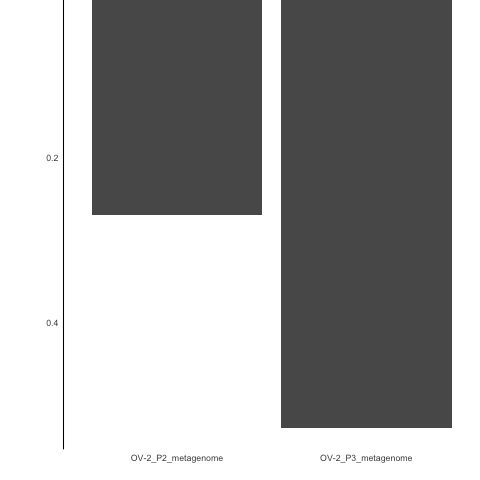

In [26]:
%%R
u <- underplot %>% ggplot(aes(metagenome, pct_metagenome)) + geom_bar(stat="identity") +  scale_y_reverse()
u <- u + theme(axis.line.y = element_line(color="black"))+ scale_x_discrete() 
punder <- u + labs(y="", x="") + theme(plot.margin=unit(c(-30,0,5,32), "pt"))
punder <- punder + theme(panel.border = element_blank(), 
                         panel.grid.major = element_blank(),
                         panel.grid.minor = element_blank(), 
                         panel.background = element_blank(), 
                         axis.ticks = element_blank(),
                         axis.line.y = element_line(color="black")) 
plot(punder)

In [23]:
%%R
total_mg_reads <- pairs[,8] %>% unique %>% sum

sideplot <- pairs %>% group_by(sag) %>% summarise(pct_reads_recruited_allmgs = (sum(total_reads_recruited)/total_mg_reads)*100)

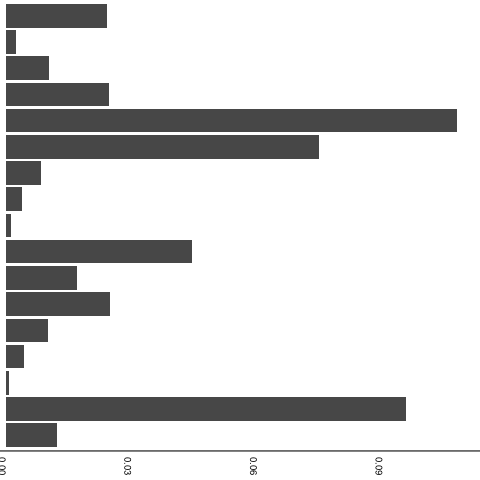

In [24]:
%%R
s <- sideplot %>% ggplot(aes(sag, pct_reads_recruited_allmgs)) + geom_bar(stat="identity") +  theme_classic()+ coord_flip()
pside <- s + theme(axis.ticks = element_blank(), axis.text.y = element_blank(), axis.title = element_blank())
pside <- pside + theme(plot.margin=unit(c(0,0,5,-20),"pt"), 
                       axis.text.x = element_text(angle = -90))
pside <- pside + theme(panel.border = element_blank(), 
                       panel.grid.major = element_blank(),
                       panel.grid.minor = element_blank(), 
                       panel.background = element_blank(),
                       axis.line.x = element_line(color="black")) 
plot(pside)

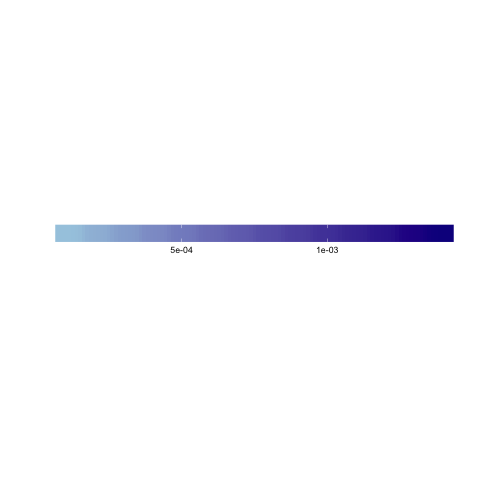

In [27]:
%%R 
legend <- pairs %>% ggplot(aes(metagenome, sag)) + geom_blank(aes(fill=prop_mgreads_per_mbp))
legend <- legend + theme(axis.text = element_blank(),
                axis.title = element_blank(),
                line = element_blank(),
                panel.background = element_blank()) + labs(fill="")
legend <- legend + theme(legend.key.width=unit(80, "pt"), 
                         legend.position=c(.5, .5), 
                 legend.direction="horizontal") + scale_fill_gradient(low="lightblue", high="darkblue")
legend <- legend + theme(plot.margin=unit(c(0,10,0,32), "pt"))

plot(legend)

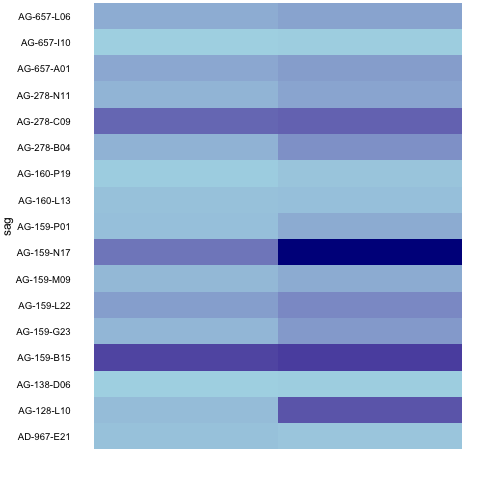

In [28]:
%%R
p1 <- pairs %>% ggplot(aes(metagenome, sag)) + geom_tile(aes(fill=prop_mgreads_per_mbp)) + theme_bw() + scale_fill_gradient(low="lightblue", high="darkblue")
pmain <- p1 + theme(axis.ticks = element_blank(), axis.title.x=element_blank(), axis.text.x=element_blank())
pmain <- pmain + theme(plot.margin=unit(c(0,0,25,0), "pt"))+labs(x=" ", fill="")
pmain <- pmain  + theme(legend.key.height=unit(50, "pt"), legend.position="none") 
pmain <- pmain + theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), panel.background = element_blank()) 


plot(pmain)

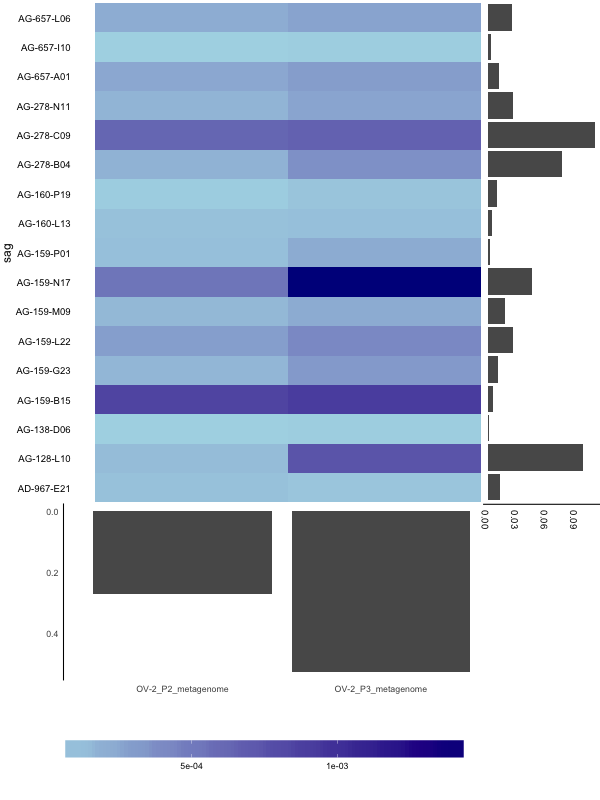

In [30]:
%%R -w 600 -h 800

pempty <-ggplot(df, aes(sag, metagenome)) + geom_blank() + theme(axis.text = element_blank(),
                axis.title = element_blank(),
                line = element_blank(),
                panel.background = element_blank(),
                plot.margin=unit(c(20,0,0,0), "pt"))



final <- grid.arrange(pmain, pside, punder, pempty,legend, pempty,
             ncol = 2, nrow = 3, widths = c(5, 1), heights = c(6, 2, 1))

In [142]:
%%R
?png
png(filename = "../data/summary_tbls/eric_SPAM_vs_OV-2mgs_160721.png",
   width=600, height=600, units="px")
plot(final)
dev.off()

quartz_off_screen 
                3 


Alternative heatmap using python packages...

In [14]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

In [17]:
df = pd.read_csv("../data/summary_tbls/160721_summary_table_pctid95_minlen150_overlap95.txt", sep="\t")

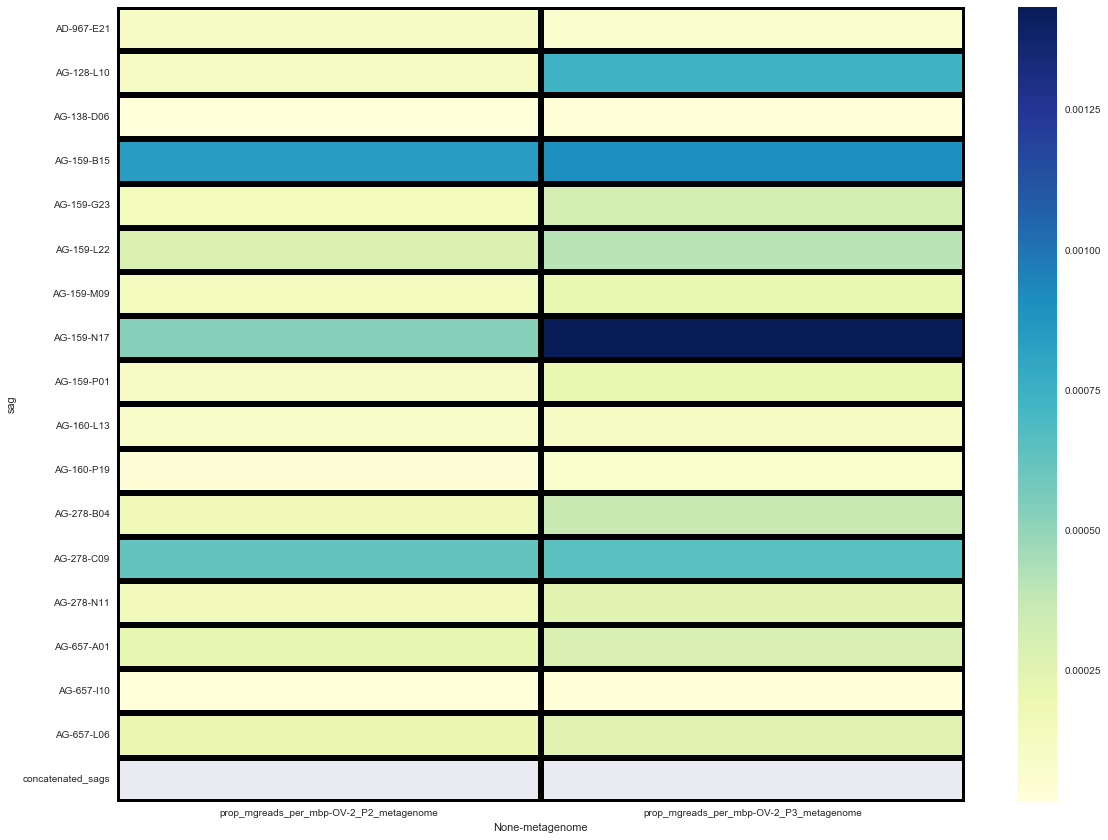

In [18]:
pmr = df[['sag','metagenome','prop_mgreads_per_mbp']].pivot(index='sag', columns='metagenome')

fig = plt.figure(figsize=(20,15))
ax1 = plt.subplot2grid((20,20), (0,0), colspan=19, rowspan=19)
#ax2 = plt.subplot2grid((20,20), (19,0), colspan=19, rowspan=1)
#ax3 = plt.subplot2grid((20,20), (0,19), colspan=1, rowspan=19)

hm = sns.heatmap(pmr, ax=ax1, annot=False, cmap="YlGnBu", linecolor='black', 
            linewidth=5, cbar = True)

In [19]:
g = df.groupby(['sag'])
newser = g['total_reads_recruited'].sum()/g['mg_read_count'].sum()
newser
#>>> data.groupby(func, axis=0).mean()
#>>> data.groupby(['col1', 'col2'])['col3'].mean()
print(newser.index)
print(newser.values)

Index([u'AD-967-E21', u'AG-128-L10', u'AG-138-D06', u'AG-159-B15',
       u'AG-159-G23', u'AG-159-L22', u'AG-159-M09', u'AG-159-N17',
       u'AG-159-P01', u'AG-160-L13', u'AG-160-P19', u'AG-278-B04',
       u'AG-278-C09', u'AG-278-N11', u'AG-657-A01', u'AG-657-I10',
       u'AG-657-L06', u'concatenated_sags'],
      dtype='object', name=u'sag')
[  1.21444253e-04   9.55768066e-04   7.53420772e-06   4.29091069e-05
   1.00850752e-04   2.49920433e-04   1.71277656e-04   4.44733519e-04
   1.23417498e-05   4.01824412e-05   8.54953191e-05   7.49294897e-04
   1.07882679e-03   2.46834996e-04   1.04617856e-04   2.50781486e-05
   2.42135085e-04   4.30149445e-03]


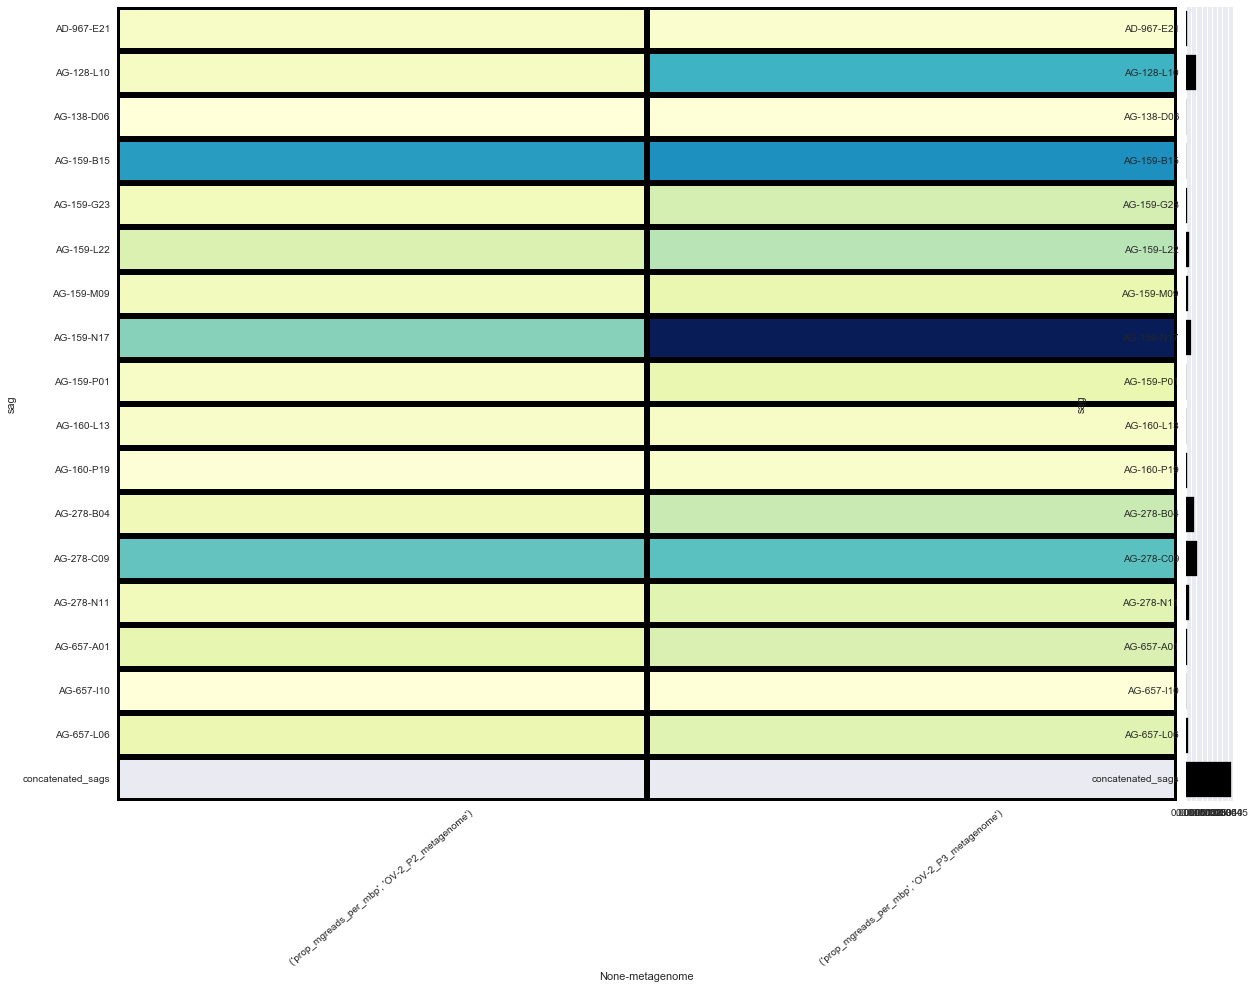

In [20]:

fig = plt.figure(figsize=(20,15))
ax1 = plt.subplot2grid((20,20), (0,0), colspan=19, rowspan=19)
#ax3 = plt.subplot2grid((20,20), (19,0), colspan=19, rowspan=1)
ax2 = plt.subplot2grid((20,20), (0,19), colspan=1, rowspan=19)

#mask = np.zeros_like(pv)
#mask[np.tril_indices_from(mask)] = True

#sns.heatmap(pv, ax=ax1, annot=True, cmap="YlGnBu",mask=mask, linecolor='b', cbar = False)
sns.heatmap(pmr, ax=ax1, annot=False, cmap="YlGnBu", linecolor='black', 
            linewidth=5, cbar = False)

ax1.set_xticklabels(pmr.columns,rotation=40)
sns.set_style("white")
sns.despine()

sns.barplot(y=newser.index, x=newser.values, color="black", ax=ax2)


#sns.heatmap((pd.DataFrame(pv.sum(axis=0))).transpose(), ax=ax2,  annot=True, cmap="YlGnBu", cbar=False, xticklabels=False, yticklabels=False)
#sns.heatmap(pd.DataFrame(pv.sum(axis=1)), ax=ax3,  annot=True, cmap="YlGnBu", cbar=False, xticklabels=False, yticklabels=False)


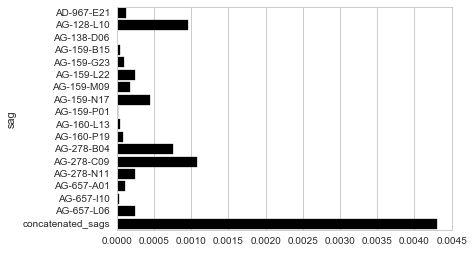

In [21]:
sns.set_style("whitegrid")
sp = sns.barplot(y=newser.index, x=newser.values, color="black")

While both heatmaps look pretty good, and the python version could likely be manipulated to look as nice as the R version, perhaps there's no reason to, as the R version will take less of a learning curve in terms of plotting.  The difficulty will be in writing the R program to execute the plotting as this is something I really haven't done before.

Working with three tables from maria's metagenome-SAG comparisons:

In [2]:
%%R

tables = list.files("../data/Maria_smr_tables/")

combine_smr_tables <- function(tablelist){
    all<-data.frame()
    for (t in tables){
        df = read.table(paste("../data/Maria_smr_tables/",t, sep=""), sep="\t", header=TRUE)
        all <- rbind(all, df) 
        }
    return(all)
    }

In [3]:
%%R
all <- combine_smr_tables(list.files("../data/Maria_smr_tables/"))
head(all)

         sag         metagenome Percent_scaffolds_with_any_coverage
1 AAA008-D05     Med-Io7-77mDCM                                 100
2 AAA008-D05    Med-Io16-70mDCM                                  NA
3 AAA008-D05 Med-Io17-3500mDeep                                  NA
4 AAA008-D05     Med-Ae1-75mDCM                                  NA
5 AAA008-D05   Med-Ae2-600mDeep                                 100
6 AAA286-M02     Med-Io7-77mDCM                                 100
  Percent_of_reference_bases_covered Average_coverage total_reads_recruited
1                          0.1674181      0.002831796                     2
2                          0.0000000      0.000000000                     0
3                          0.0000000      0.000000000                     0
4                          0.0000000      0.000000000                     0
5                          0.8699128      0.016174803                    19
6                          0.9465870      0.022387628               

In [44]:
%%R 
# returns a dataframe with metagenome name and percent metagenome recruited to all SAGs
# values to be used for the underplot
summarise_mgs <- function(df){
    mg_summary <- df %>% filter(sag == "concatenated_sags") %>% .[,c(1:8)]
    total_sag_bp <- all %>% .[,c(1,10)] %>% unique %>% filter(sag != "concatenated_sags") %>% .[,2] %>% sum 
    mg_summary$total_sag_bp <- total_sag_bp
    mg_summary$sag_size_mbp <- total_sag_bp/1000000
    mg_summary <- mg_summary %>% mutate(reads_per_mbp=total_reads_recruited/sag_size_mbp, 
                                        prop_mgreads_per_mbp=(total_reads_recruited/sag_size_mbp)/mg_read_count,
                                       pct_metagenome=(total_reads_recruited/mg_read_count)*100)
    underplot <- mg_summary[,c(2,ncol(mg_summary))]
    return(underplot)
}

In [5]:
%%R
mg_summary <- summarise_mgs(all)

In [45]:
%%R
# summarise the number of total mg reads recruited to each SAG
# for the side plot of the heatmap

summarise_sags <- function(df){
    pairs <- df %>% filter(sag != "concatenated_sags")
    total_mg_reads <- pairs[,8] %>% unique %>% sum
    sideplot <- pairs %>% group_by(sag) %>% summarise(pct_reads_recruited_allmgs = (sum(total_reads_recruited)/total_mg_reads)*100)
    return(sideplot)
}

In [7]:
%%R
sag_summary <- summarise_sags(all)

In [60]:
%%R
str(all)

'data.frame':	1204 obs. of  13 variables:
 $ sag                                : Factor w/ 43 levels "AAA008-D05","AAA286-M02",..: 1 1 1 1 1 2 2 2 2 2 ...
 $ metagenome                         : Factor w/ 28 levels "Med-Ae1-75mDCM",..: 5 3 4 1 2 5 3 4 1 2 ...
 $ Percent_scaffolds_with_any_coverage: num  100 NA NA NA 100 100 NA NA NA 100 ...
 $ Percent_of_reference_bases_covered : num  0.167 0 0 0 0.87 ...
 $ Average_coverage                   : num  0.00283 0 0 0 0.01617 ...
 $ total_reads_recruited              : int  2 0 0 0 19 4 0 0 0 115 ...
 $ mg_wgs_technology                  : Factor w/ 1 level "illumina": 1 1 1 1 1 1 1 1 1 1 ...
 $ mg_read_count                      : int  41887523 29504883 23269297 24783541 66478097 41887523 29504883 23269297 24783541 66478097 ...
 $ sag_completeness                   : num  25.9 25.9 25.9 25.9 25.9 ...
 $ sag_total_bp                       : num  608374 608374 608374 608374 608374 ...
 $ sag_size_mbp                       : num  0.608 0.608

In [67]:
%%R
pairs <- all %>% filter(sag != "concatenated_sags")
maxcol <- max(pairs$prop_mgreads_per_mbp)
maxcol

[1] 0.00212332


In [40]:
%%R
main_heatmap <- function(df, lowcolor="white",midcolor="lightblue", highcolor="darkblue"){
    pairs <- df %>% filter(sag != "concatenated_sags")
    maxcol <- max(pairs$prop_mgreads_per_mbp)
    p1 <- pairs %>% ggplot(aes(metagenome, sag)) + geom_tile(aes(fill=prop_mgreads_per_mbp)) + theme_bw() 
    pmain <- p1 + theme(axis.ticks = element_blank(), axis.title.x=element_blank(), axis.text.x=element_blank())
    pmain <- pmain + labs(x=" ", fill="") + scale_fill_gradientn(colours=c(lowcolor,midcolor,highcolor), values=c(0,0.00001,1))
    pmain <- pmain  + theme(legend.key.height=unit(50, "pt"), legend.position="none") 
    pmain <- pmain + theme(panel.border = element_blank(), 
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(), 
                           panel.background = element_blank()) 
    return(pmain)
}


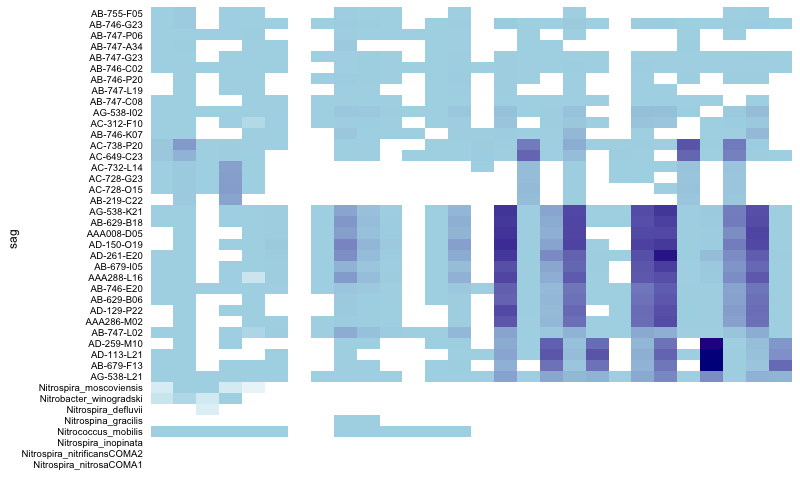

In [41]:
%%R -w 800
main_heatmap(all)
main_heatmap(all)

In [48]:
%%R
mg_plot <- function(df){
    underplot <- summarise_mgs(df)
    u <- underplot %>% ggplot(aes(metagenome, pct_metagenome)) + geom_bar(stat="identity", fill="white", color="black") +  scale_y_reverse()
    u <- u + theme(axis.line.y = element_line(color="black"))+ scale_x_discrete() 
    punder <- u + labs(y="", x="") + theme(axis.text.x  = element_text(angle=90, face="bold"))
    punder <- punder + theme(panel.border = element_blank(), 
                             panel.grid.major = element_blank(),
                             panel.grid.minor = element_blank(), 
                             panel.background = element_blank(), 
                             axis.ticks = element_blank(),
                             axis.line.y = element_line(color="black")) 
    return(punder)
    }

In [50]:
%%R
mgplot <- summarise_mgs(all)


Error in `$<-.data.frame`(`*tmp*`, "total_sag_bp", value = 61118126) : 
  replacement has 1 row, data has 0


In [47]:
%%R
sag_plot <- function(df){
    sideplot <- summarise_sags(df)
    s <- sideplot %>% ggplot(aes(sag, pct_reads_recruited_allmgs)) + geom_bar(stat="identity", fill="white", color="black") +  theme_classic()+ coord_flip()
    pside <- s + theme(axis.ticks = element_blank(), axis.text.y = element_blank(), axis.title = element_blank())
    pside <- pside + theme(axis.text.x = element_text(angle = -90))
    pside <- pside + theme(panel.border = element_blank(), 
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(), 
                           panel.background = element_blank(),
                           axis.line.x = element_line(color="black")) 
    return(pside)

}

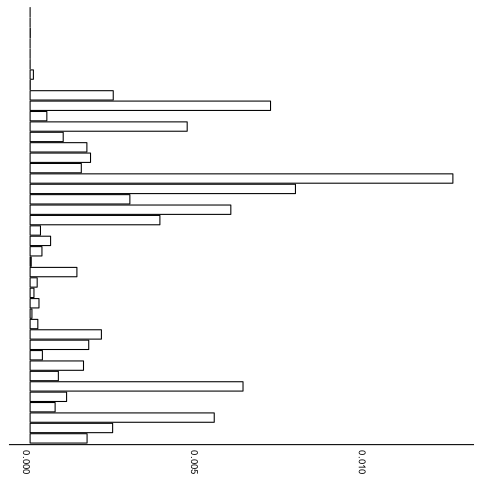

In [48]:
%%R
sag_plot(all)

In [49]:
%%R
empty_plot <- function(df){
    pempty <-ggplot(df, aes(sag, metagenome)) + geom_blank() + theme(axis.text = element_blank(),
                axis.title = element_blank(),
                line = element_blank(),
                panel.background = element_blank())
    return(pempty)
}

In [72]:
%%R
hm_legend <- function(df, lowcolor="white",midcolor="lightblue", highcolor="darkblue"){
    pairs <- df %>% filter(sag != "concatenated_sags")
    legend <- pairs %>% ggplot(aes(metagenome, sag)) + geom_blank(aes(fill=prop_mgreads_per_mbp))
    legend <- legend + theme(axis.text = element_blank(),
                    axis.title = element_blank(),
                    line = element_blank(),
                    panel.background = element_blank()) + labs(fill="")
    legend <- legend + theme(legend.key.width=unit(80, "pt"), 
                             legend.position=c(.5, .5), 
                     legend.direction="horizontal") 
    legend <- legend + scale_fill_gradientn(colours=c(lowcolor,midcolor,highcolor), values=c(0,0.00001,1))
    return(legend)

}

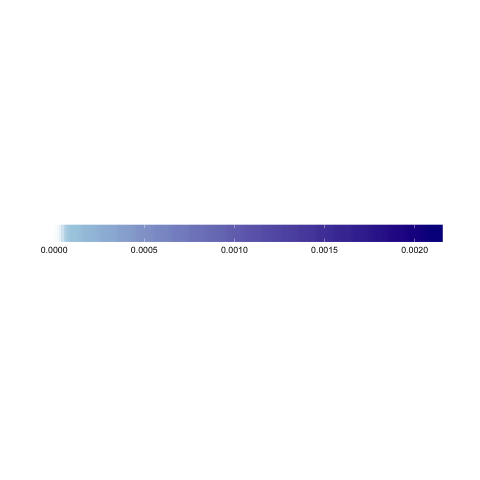

In [73]:
%%R
hm_legend(all)

In [57]:
%%R
# margin adjustments
plot_array <- function(df, lowcolor="white",midcolor="lightblue", highcolor="darkblue"){
    heatmap <- main_heatmap(df)
    mgplot <- mg_plot(df)
    sagplot <- sag_plot(df)
    empty <- empty_plot(df)
    legend <- hm_legend(df)
    heatmap <- heatmap + theme(plot.margin=unit(c(0,0,28,0), "pt"))
    mgplot <- mgplot + theme(plot.margin=unit(c(-28,0,0,105),"pt"))
    sagplot <- sagplot + theme(plot.margin=unit(c(0,0,0,0), "pt")) #+ theme(plot.margin=unit(c(0,0,-25,0), "pt"))
    empty <- empty + theme(plot.margin=unit(c(50,0,0,0), "pt"))
    legend <- legend + theme(plot.margin=unit(c(0,0,0,105), "pt"))
    
    final <- grid.arrange(heatmap, sagplot, mgplot, empty, legend, empty,
             ncol = 2, nrow = 3, widths = c(6, 1), heights = c(8, 3, 1))
    return(final)
    
    }

In [58]:
%%R -w 800 -h 600
plot_array(all)


Error in `$<-.data.frame`(`*tmp*`, "total_sag_bp", value = 61118126) : 
  replacement has 1 row, data has 0


Next will be to consider how to re-order mgs and SAGs.

In [61]:
%%R
## clustering columns and rows:
pairs <- all %>% filter(sag != "concatenated_sags")
edgelist <- pairs[,c(1,2,13)]
str(edgelist)

'data.frame':	1176 obs. of  3 variables:
 $ sag                 : Factor w/ 42 levels "Nitrospira_nitrosaCOMA1",..: 22 22 22 22 22 14 14 14 14 14 ...
 $ metagenome          : Factor w/ 28 levels "Med-Ae1-75mDCM",..: 5 3 4 1 2 5 3 4 1 2 ...
 $ prop_mgreads_per_mbp: num  7.85e-08 0.00 0.00 0.00 4.70e-07 ...


In [95]:
%%R
create_adjtbl <- function(edgelist){
    yaxis = unique(edgelist[,2])
    together <- data.frame(unique(edgelist[,1]))
    colnames(together)[1] <- colnames(edgelist)[1]
    for (m in seq(1,length(yaxis))){
        es <- edgelist %>% filter(.[,2]==yaxis[m])
        colnames(es)[3] <- as.character(yaxis[m])
        to_combine <- es[,c(1,3)]
        together = merge(together, to_combine, by=colnames(es)[1])
    }
    return(together)
    }

In [94]:
%%R
e2 <- pairs[,c(2,1,13)]
yaxis = unique(e2[,2])
together <- data.frame(unique(e2[,1]))
colnames(together)[1] <- colnames(e2)[1]
head(together)

          metagenome
1     Med-Io7-77mDCM
2    Med-Io16-70mDCM
3 Med-Io17-3500mDeep
4     Med-Ae1-75mDCM
5   Med-Ae2-600mDeep
6     Mex_OMZ_St6_30


In [86]:
%%R
clust_order_x <- function(edgelist){
    adj <- create_adjtbl(edgelist)
    rownames(adj) <- adj[,1]
    adj[,1] <- NULL
    mat1 <- as.matrix(adj)
    xdist <- mat1 %>% vegdist(method="bray") 
    xdist[is.na(xdist)] <- 1
    xdist %>% hclust -> xclust
    xdend <- as.dendrogram(xclust)
    xorder <- order.dendrogram(xdend)
    data <- mat1[xorder,]
    levels <- seq(1, nrow(data))
    xorder <- cbind.data.frame(rownames(data), levels)
    colnames(xorder)[1] <- colnames(edgelist)[1]
    return(xorder)
    }




In [96]:
%%R
print(clust_order_x(pairs[c(2,1,13)]))
#print(clust_order_y(edgelist))
#head(edgelist)
#pairs$sag <- with(pairs, factor(pairs, levels = sagorder[,1]))

           metagenome levels
1     Mex_OMZ_St10_30      1
2     Med-Io16-70mDCM      2
3      Mex_OMZ_St6_30      3
4             Japan_0      4
5      Med-Ae1-75mDCM      5
6      Med-Io7-77mDCM      6
7          Ogsawara_0      7
8    Mex_OMZ_St10_125      8
9     Mex_OMZ_St6_125      9
10   Mex_OMZ_St10_300     10
11    Mex_OMZ_St6_300     11
12 Med-Io17-3500mDeep     12
13   Med-Ae2-600mDeep     13
14          Japan_193     14
15       Ogsawara_306     15
16         Japan_7007     16
17      Ogsawara_9697     17
18         Japan_3499     18
19      Ogsawara_5010     19
20    Mex_OMZ_St6_100     20
21    Mex_OMZ_St10_85     21
22     Mex_OMZ_St6_85     22
23       Ogsawara_505     23
24      Ogsawara_1206     24
25          Japan_547     25
26       Ogsawara_754     26
27         Japan_1000     27
28      Ogsawara_2015     28


In [56]:
%%R
plot_array(all)


Error in withVisible({ : could not find function "plot_array"


ls: cifs://storage.bigelow.org/: No such file or directory
